In [1]:
# from tqdm import tqdm
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

In [3]:
# from datasets import Myloader
# from networks_pyg.init import init_model
# from utils.utils import get_congestion_start_end

In [4]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [5]:
%load_ext autoreload
%autoreload 2

In [239]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
# filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('./data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    speed_all2 = speed_all.copy()
    # Day of Week => monday : 0, sunday : 6
    speed_all2['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all2['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all2.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all2.groupby(['weekday', 'timestamp']).std()
    
    speed_all2 = speed_all2.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all2, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [11]:
accident_all['accident_sid'].value_counts()

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
              ..
2210066900     1
1120013402     1
1100005401     1
1070010402     1
1040020100     1
Name: accident_sid, Length: 482, dtype: int64

In [336]:
    target_sid = 1210005301 ## 1030001902    ## 1210005301
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'standard'

    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

#         df_all_norm = df_all_norm.rolling(3).mean()

#     # define anomaly label
#     labels = []
#     accident_case['created'] = pd.to_datetime(accident_case['created'])
#     for ix, row in accident_case.iterrows():
#         accident_created = row['created']
#         min = accident_created.minute % 5
#         sec = accident_created.second
#         accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
#         labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
#     labels = list(map(int, (np.sum(labels, axis=0) > 0)))
#     label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])

In [337]:
# from datasets.Myloader import traffic_loader

# train_loader, val_loader, test_loader = traffic_loader(args, target_sid)
# len(train_loader), len(val_loader), len(test_loader)

In [338]:
## smoothing
rolling_window = 6
speed_all = speed_all.rolling(rolling_window).mean()
# speed_all = speed_all.iloc[rolling_window-1:]

## nan value
speed_all = speed_all.bfill(limit=36).ffill(limit=36).fillna(0, limit=288*10).dropna(axis=1)

In [339]:
speed_all.shape

(51840, 25)

## Incident Region Map images

In [68]:
accident_case.shape

(20, 13)

In [12]:
import folium

In [47]:
target_sid = 1210005301
with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
    test = pickle.load(f)
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [48]:
path_inflow = path_inflow[1:]

In [49]:
lat = accident_case.lat[0]
lng = accident_case.lng[0]
M = folium.Map((lat, lng), zoom_start=15)

# icon_star = plugins.BeautifyIcon(
#     icon='star',
#     inner_icon_style='color:red;font-size:20px;',
#     background_color='transparent',
#     border_color='transparent',
# )

# for eventID in selected_ID:
eventID = str(eventID)

# with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
#     accident_info = pickle.load(f)
    
# folium.Circle((accident_info[0]['lat'], accident_info[0]['lng']),
#             radius = 100,
#             color = 'black',
#             opacity = 0.8,
#             fill_color = 'black').add_to(M)

H = nx.subgraph(G, np.unique(path_inflow))

for e in H.edges:
    start = H.nodes('pos')[e[0]][::-1]
    end = H.nodes('pos')[e[1]][::-1]
    
    if e[0] in np.array(path_inflow)[:,1]:
        cc = 'red'
    elif e[0] in np.array(path_inflow)[:,2]:
        cc = 'blue'
    elif e[0] in np.array(path_inflow)[:,3]:
        cc = 'green'
    
    folium.PolyLine(
        locations=[start, end],
        color=cc, weight=5
    ).add_to(M)

H = nx.subgraph(G, np.unique(path_outflow))

for e in H.edges:
    start = H.nodes('pos')[e[0]][::-1]
    end = H.nodes('pos')[e[1]][::-1]
    
    if e[0] in np.array(path_outflow)[:,1]:
        cc = 'green'
    elif e[0] in np.array(path_outflow)[:,2]:
        cc = 'blue'
    elif e[0] in np.array(path_outflow)[:,3]:
        cc = 'red'
    
    folium.PolyLine(
        locations=[start, end],
        color=cc, weight=5
    ).add_to(M)

folium.Marker(
    [H.nodes('pos')[accident_sid][1], H.nodes('pos')[accident_sid][0]], 
    tooltip='incident'#, icon=icon_star
).add_to(M)

M

In [25]:
lng

127.01374248595889

## Normal Data

In [340]:
path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

In [343]:
path_outflow = path_outflow[:-1]

In [344]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(speed_all[inflow].mean(axis=1))
    df_agg_outflow.append(speed_all[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

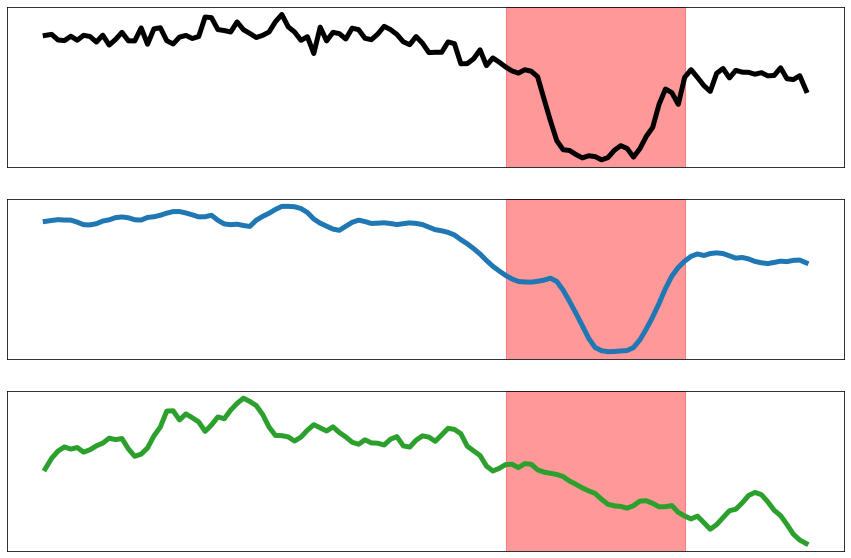

In [345]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
ax[0].plot(df_all_norm[580:700][accident_sid], color='k', lw=5)
ax[1].plot(df_agg_inflow[580:700][1], lw=5)
ax[2].plot(df_agg_outflow[580:700][1], color='tab:green', lw=5)
for i in range(3):
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].axvspan(df_all_norm.index[652], df_all_norm.index[680], color='r', alpha=0.4)

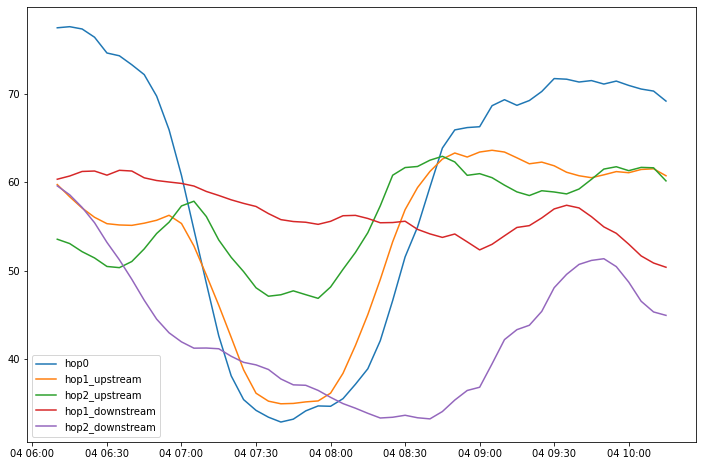

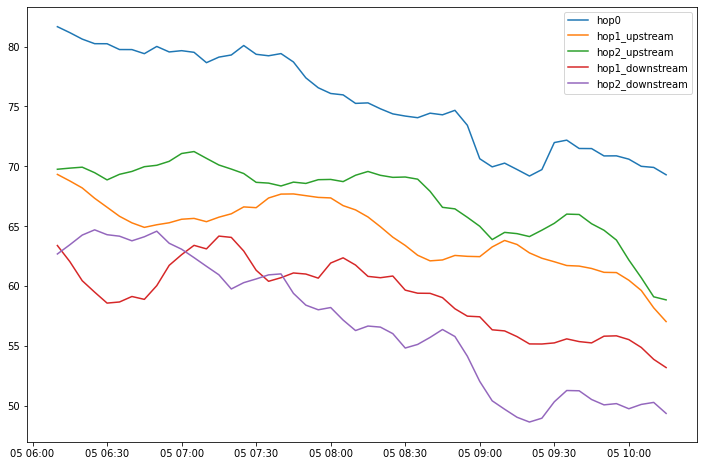

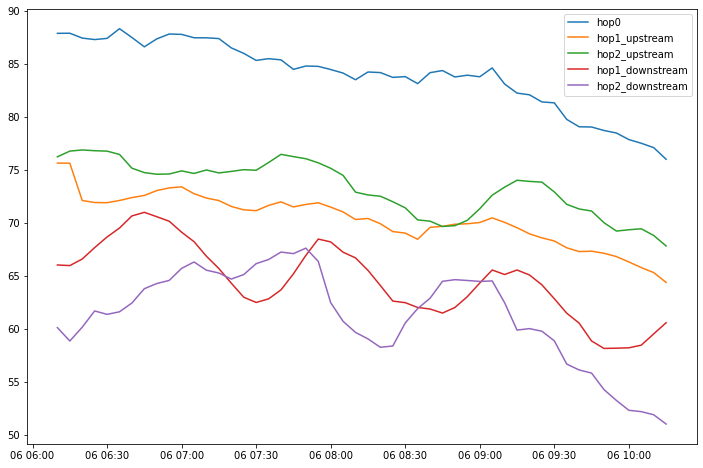

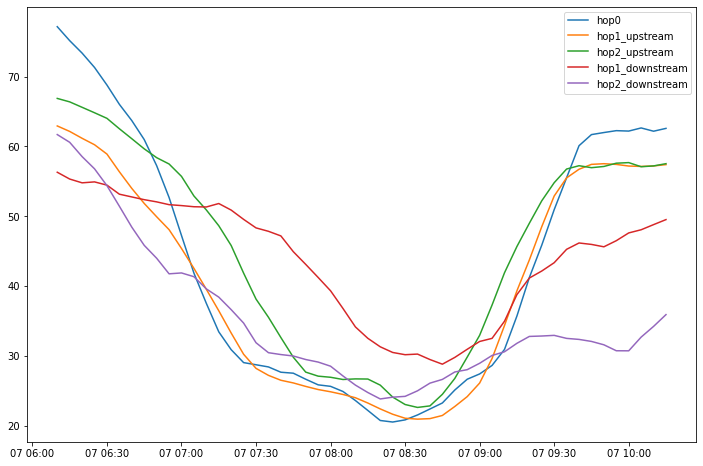

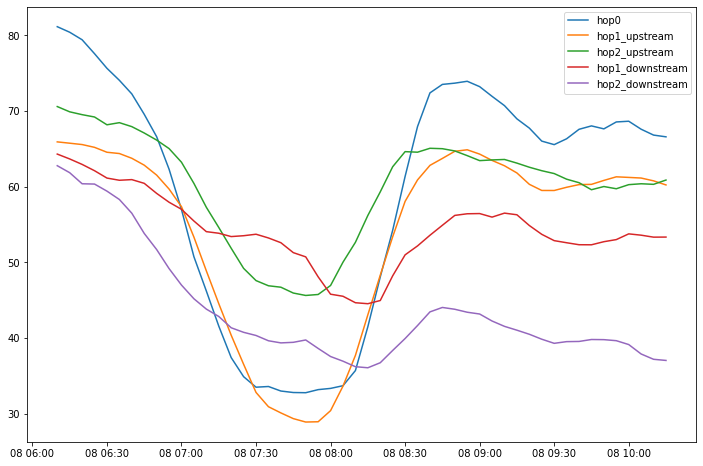

In [346]:
for i in range(5):
    t0 = 650 + 288*i
    t1 = 700 + 288*i
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow.iloc[t0:t1][0], label='hop0')
    plt.plot(df_agg_inflow[t0:t1][1], label='hop1_upstream')
    plt.plot(df_agg_inflow[t0:t1][2], label='hop2_upstream')
    plt.plot(df_agg_outflow[t0:t1][1], label='hop1_downstream')
    plt.plot(df_agg_outflow[t0:t1][2], label='hop2_downstream')
    plt.legend()
    plt.show()

## Detect Congestion

### accident road

In [347]:
ff_speed = speed_all.quantile(q=0.85, axis=0)
cong_speed = ff_speed * 0.6
ff_speed, cong_speed

(sid
 1210004801     78.535240
 1210004802     87.796193
 1210005304    101.647028
 1210005305    101.960181
 1210065700     68.878265
 1210066100     62.583333
 1210066300     58.098493
 1220004700     39.092662
 1220095000     51.652476
 1220096900     56.867467
 1220342100     46.474171
 1220342500    102.211106
 1220342700     77.097735
 1020026801     49.994353
 1020056400     75.483760
 1210004500     93.966592
 1210004901     92.507972
 1210004902     84.441769
 1210005402     95.720562
 1210060300     74.723479
 1210062100     38.411872
 1210062500     46.063931
 1210062700     66.239555
 1210158699     36.592638
 1210005301     88.815074
 Name: 0.85, dtype: float64,
 sid
 1210004801    47.121144
 1210004802    52.677716
 1210005304    60.988217
 1210005305    61.176109
 1210065700    41.326959
 1210066100    37.550000
 1210066300    34.859096
 1220004700    23.455597
 1220095000    30.991486
 1220096900    34.120480
 1220342100    27.884503
 1220342500    61.326663
 1220342700

In [348]:
# congestion_index = speed_all[target_sid] < cong_speed[target_sid]

In [258]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12][target_sid]
    if ts.mean() < cong_speed[target_sid]:
        congestion_label.iloc[i+12] = 1
        

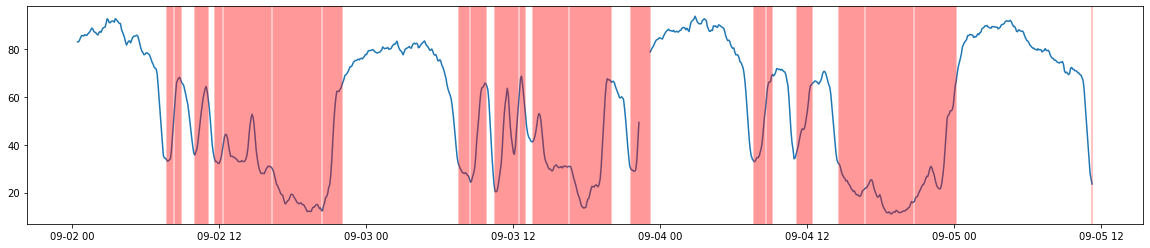

In [259]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:1000][target_sid])

for i in range(1000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

### all roads

In [436]:
(speed_all[i:i+12].mean(axis=0) < cong_speed).sum()

1

In [437]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])
for i in range(len(speed_all)-12):
    ts = speed_all[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.5*speed_all.shape[1]:
        congestion_label.iloc[i+12] = 1
        

In [492]:
ff_speed = df_all_norm.quantile(q=0.85, axis=0)
cong_speed = ff_speed * 0.6

In [493]:
congestion_label = pd.DataFrame(0, index=df_all_norm.index, columns=['RC'])
for i in range(len(df_all_norm)-12):
    ts = df_all_norm[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.5*df_all_norm.shape[1]:
        congestion_label.iloc[i+12] = 1

In [494]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    df_agg_inflow.append(df_all_norm[inflow].mean(axis=1))
    df_agg_outflow.append(df_all_norm[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

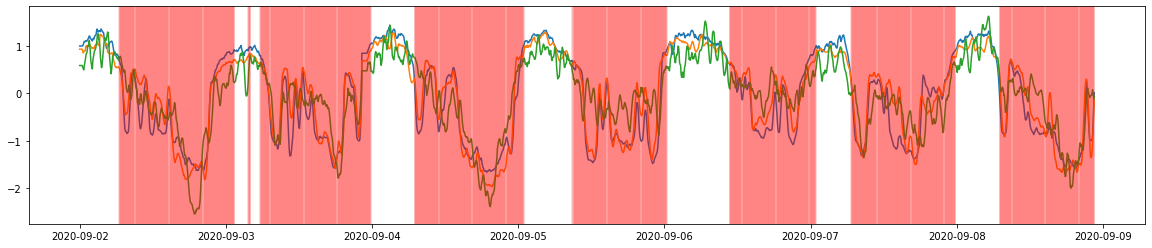

In [495]:
plt.figure(figsize=(20,4))
plt.plot(df_all_norm[:2000][target_sid])
plt.plot(df_agg_inflow[:2000][1])
plt.plot(df_agg_outflow[:2000][1])

for i in range(2000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.2, color='r')

### 0.6 * s^*(s,t)

In [244]:
_, profile_mean, profile_std = profile_extraction2(speed_all)

In [213]:
congestion_label = pd.DataFrame(0, index=speed_all.index, columns=['RC'])

In [214]:
dt_ = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1))
for dt in dt_:
    dt = pd.to_datetime(dt)
    new_dt = datetime(dt.year, dt.month, dt.day) 
    new_period = pd.date_range(new_dt, new_dt + timedelta(days=1), freq='5min')[:-1]
    weekday = new_dt.weekday()
    profile_dt = profile_mean.loc[weekday,:]
    congestion = speed_all.loc[new_period][target_sid].values < 0.6 * profile_dt[target_sid].values
    
    congestion_label.loc[new_period, 'RC'] = congestion.astype(int)

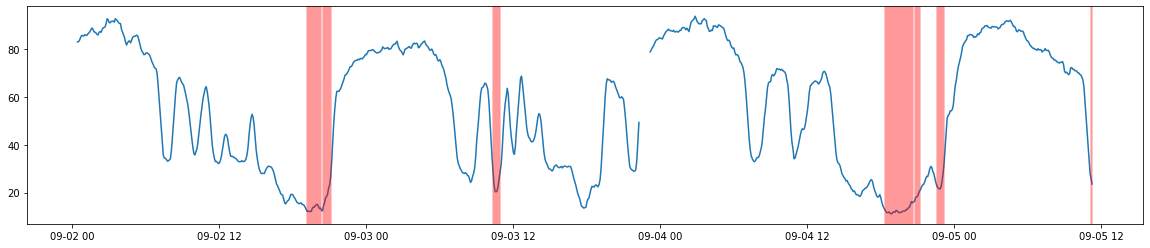

In [215]:
plt.figure(figsize=(20,4))
plt.plot(speed_all[:1000][target_sid])

for i in range(1000):
    if congestion_label.RC[i] == 1:
        plt.axvline(congestion_label.index[i], alpha=0.3, color='r')

## Incident Data

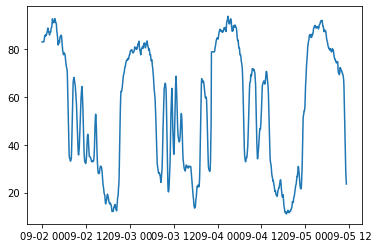

In [448]:
plt.plot(speed_all[:1000][target_sid])

In [454]:
speed_all.shape

(51840, 25)

In [453]:
## smoothing
rolling_window = 6
df_all_norm = df_all_norm.rolling(rolling_window).mean()
# speed_all = speed_all.iloc[rolling_window-1:]

## nan value
df_all_norm = df_all_norm.bfill(limit=36).ffill(limit=36).fillna(0, limit=288*10).dropna(axis=1)
df_all_norm.shape

(51840, 25)

In [461]:
congestion_label['NRC'] = 0

/tmp/ipykernel_3765033/563597723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


!!!
!!!
!!!
!!!
!!!
!!!
!!!
!!!


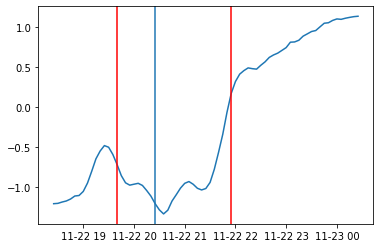

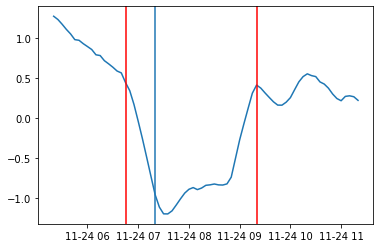

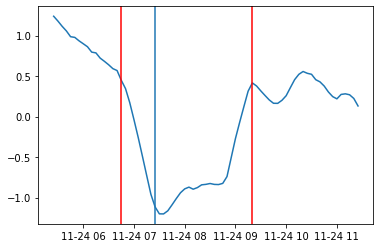

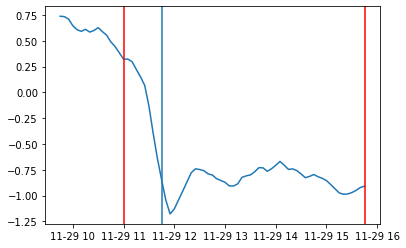

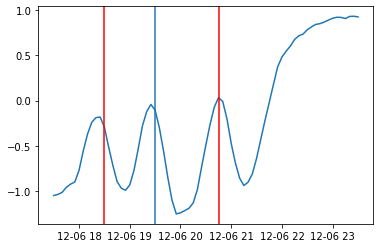

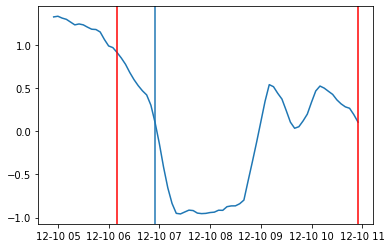

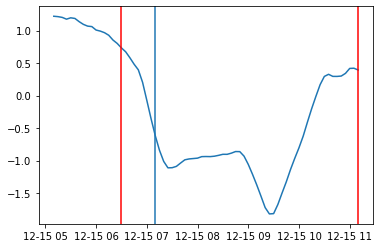

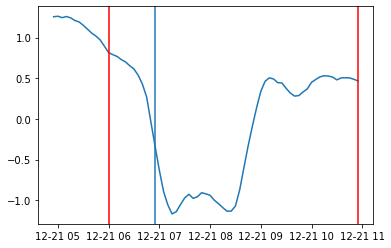

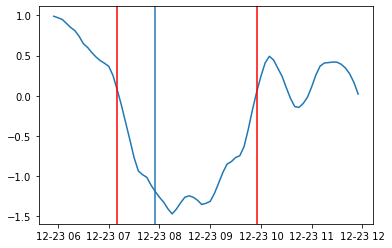

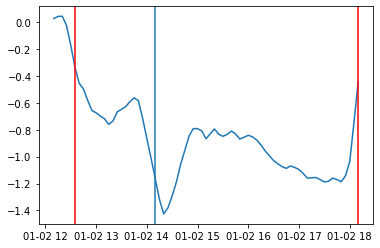

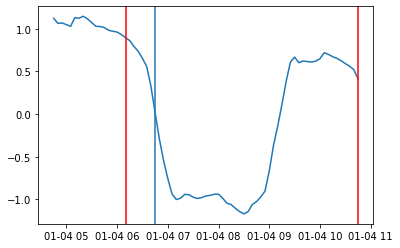

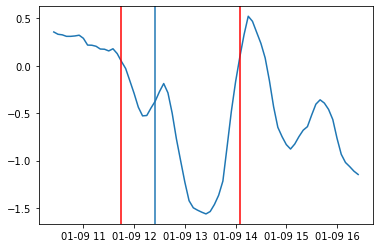

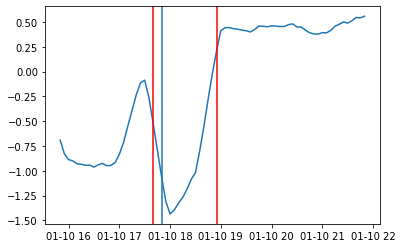

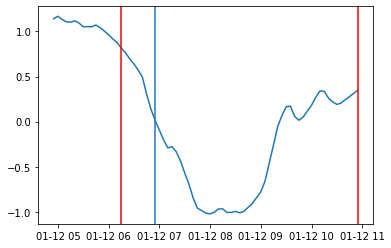

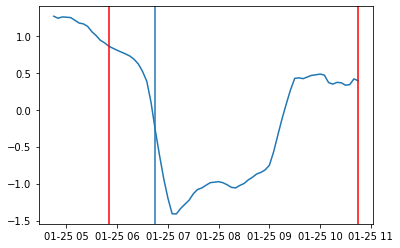

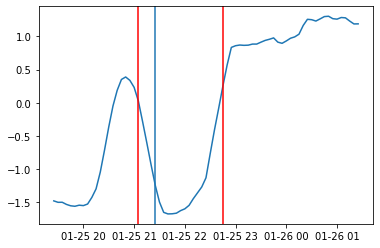

In [462]:
label_df = pd.DataFrame(0, index=df_all_norm.index, columns=['label'])
cnt = 0
plot=True

## Incident Data Plot
accident_case['created'] = pd.to_datetime(accident_case['created'])

for ix, row in accident_case.iterrows():
    t = row['created']
    accident_sid = row['accident_sid']
#     if (t.month != 1) and (t.month != 12):
#         continue
    if (t.month == 2):
        continue

    
    eventID = str(row['eventId'])
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
        
    accident_dt = accident_info[0]['created'].to_pydatetime()
    accident_dt = datetime.fromtimestamp(round(accident_dt.timestamp()/300)*300)
    accident_idx = np.where(df_all_norm.index == accident_dt)[0][0]
    df_pre = df_all_norm[accident_dt - timedelta(minutes=120):accident_dt]
    if df_pre.mean()[accident_sid] > 0:
        df_start_condition = (df_pre.mean() > df_all_norm)[accident_sid]
    else:
        df_start_condition = (df_pre.quantile(0.8) > df_all_norm)[accident_sid]
    df_start_condition = df_start_condition.astype(int).diff()==1
    
    congestion_start_list = np.where(df_start_condition==True)[0]
    congestion_start_list = np.unique([idx for idx in congestion_start_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    if len(congestion_start_list) == 0:
        congestion_start_time = accident_dt
    else:
        congestion_start_time = df_all_norm.index[congestion_start_list[0]].to_pydatetime()

#     df_end_condition = (df_pre.mean() < df_all_norm)[accident_sid]
#     congestion_end_list = np.where(df_end_condition==True)[0]
#     congestion_end_list = np.unique([idx for idx in congestion_end_list if (accident_idx - 12*2 <= idx) & (idx <= accident_idx)])
    
    df_avg_pre_new = df_all_norm[congestion_start_time - timedelta(minutes=60):accident_dt]
    zero_condition = pd.DataFrame(0, index=df_avg_pre_new.index, columns=df_avg_pre_new.columns)
    df_end_condition = (np.maximum(zero_condition.mean(), df_avg_pre_new.mean()) < df_all_norm)[accident_sid]
    df_end_condition = df_end_condition.astype(int).diff()==1
    congestion_end_list = np.where(df_end_condition==True)[0]
    congestion_end_list = [idx for idx in congestion_end_list if (accident_idx <= idx) & (idx <= accident_idx + 12*4)]
    if len(congestion_end_list) == 0:
        print("!!!")
        congestion_end_list = [accident_idx+12*4]
    congestion_end_time = df_all_norm.index[congestion_end_list[0]].to_pydatetime()

#     congestion_start_time, congestion_end_time, _ = get_congestion_start_end(df_avg, accident_info, std_min=30, start_period=12*2, end_period=12*24, gap=120/5)
    if plot==True:
        plt.figure()
        plt.plot(df_all_norm[accident_dt+timedelta(minutes=-120) :accident_dt+timedelta(minutes=240)][target_sid])
        plt.axvline(congestion_start_time, color='red')
        plt.axvline(congestion_end_time, color='red')
        plt.axvline(accident_dt)
        
    cnt += 1
    ## Label generation
#     label_df[congestion_start_time:congestion_end_time] = 1
    congestion_label.loc[congestion_start_time:congestion_end_time, 'NRC'] = 1

    

In [463]:
congestion_label['NRC'].value_counts()

0    51178
1      662
Name: NRC, dtype: int64

In [483]:
congestion_label['RC'].value_counts()

0    42095
1     9745
Name: RC, dtype: int64

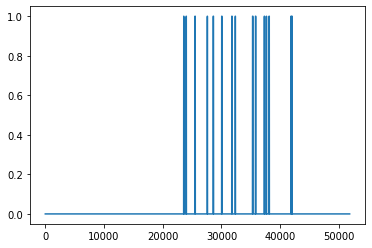

In [467]:
plt.plot(congestion_label['NRC'].values)

In [472]:
test_label = congestion_label[(congestion_label.index >= datetime(2021, 1, 1)) & (congestion_label.index < datetime(2021, 2, 1))]

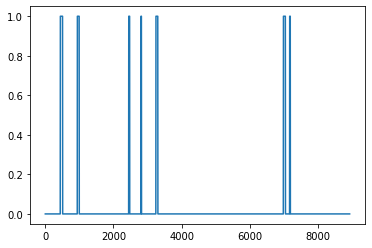

In [473]:
plt.plot(test_label['NRC'].values)

In [480]:
train_label = pd.read_csv('./data/{}/train_y.csv'.format(target_sid), index_col=0)
val_label = pd.read_csv('./data/{}/val_y.csv'.format(target_sid), index_col=0)
test_label = pd.read_csv('./data/{}/test_y.csv'.format(target_sid), index_col=0)

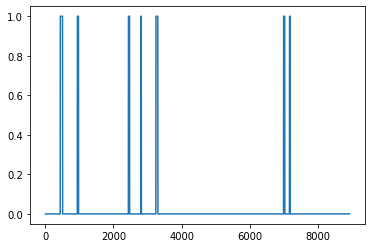

In [481]:
plt.plot(test_label.values)

In [482]:
test_label.value_counts()

label
0        8663
1         265
dtype: int64

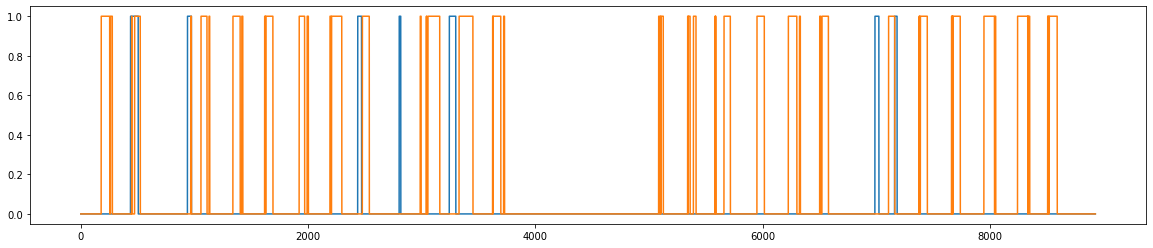

In [369]:
plt.figure(figsize=(20,4))
plt.plot(test_label.values)
plt.plot(congestion_label[-len(test_label):].values)

In [440]:
congestion_label['NRC'] = 0
congestion_label.loc[train_label.index, 'NRC'] = train_label.label.values
congestion_label.loc[val_label.index, 'NRC'] = val_label.label.values
congestion_label.loc[test_label.index, 'NRC'] = test_label.label.values

In [441]:
congestion_label['NRC'].value_counts()

0    51264
1      576
Name: NRC, dtype: int64

In [468]:
congestion_label[(congestion_label['NRC'] == 1)&congestion_label.RC==1]

,RC,NRC
datetime,,
2020-11-24 08:35:00,1,1
2020-11-24 08:40:00,1,1
2020-11-24 08:45:00,1,1
2021-01-09 13:20:00,1,1
2021-01-09 13:25:00,1,1
2021-01-09 13:45:00,1,1
2021-01-09 13:50:00,1,1
2021-01-09 13:55:00,1,1
2021-01-09 14:00:00,1,1


In [373]:
# NRC_label = pd.concat([train_label, val_label, test_label])
# NRC_label_all = pd.DataFrame(list(NRC_label.values.reshape(-1)) + [0] * 8066, index=speed_all.index, columns=['NRC'])

2021-01-02 14:10:00
2021-01-04 06:46:00
2021-01-09 12:27:00
2021-01-10 17:52:00
2021-01-12 06:54:00
2021-01-25 06:46:00
2021-01-25 21:23:00


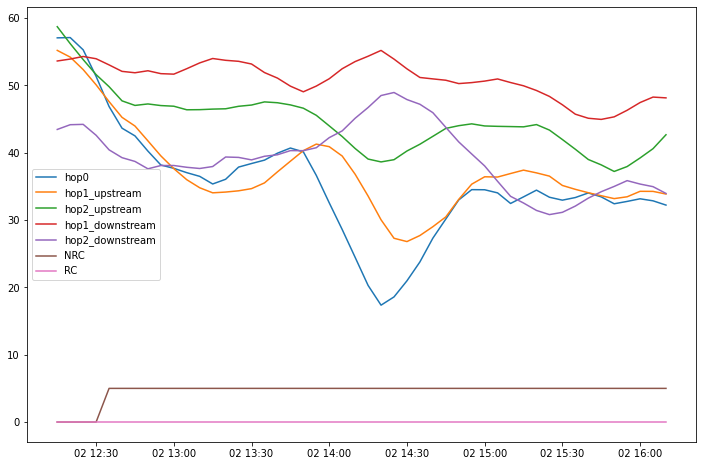

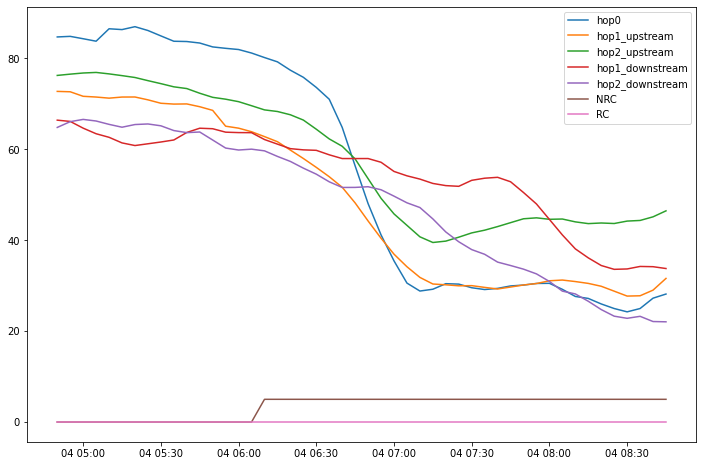

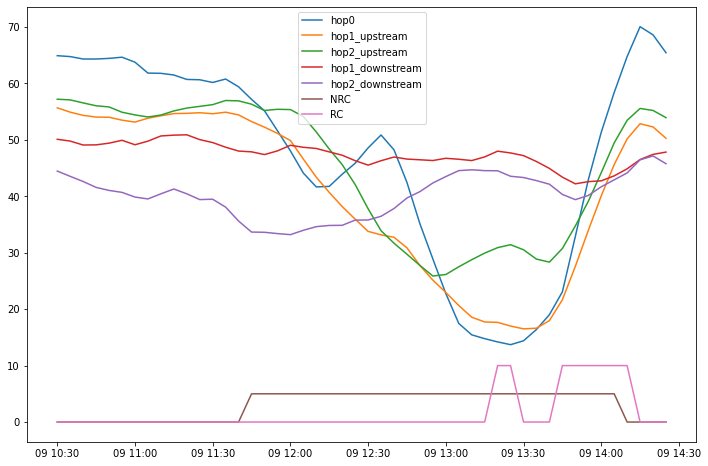

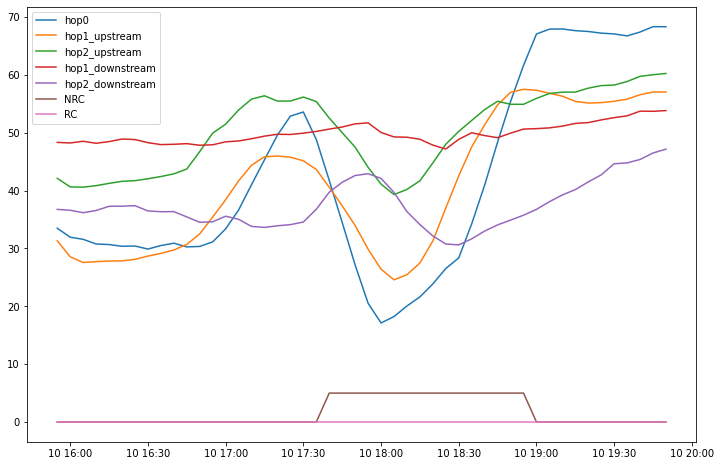

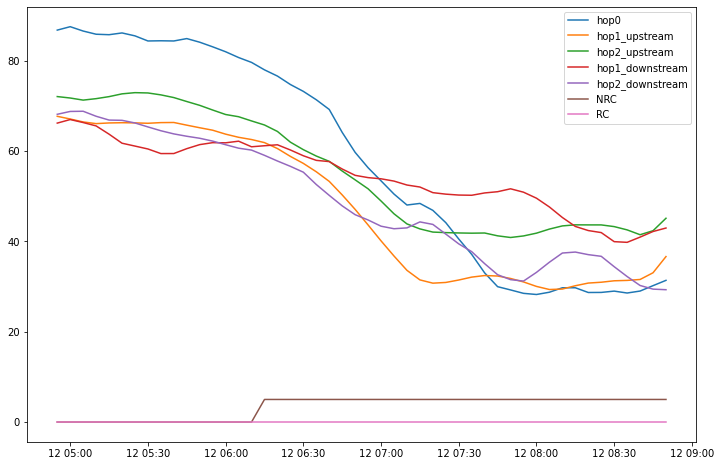

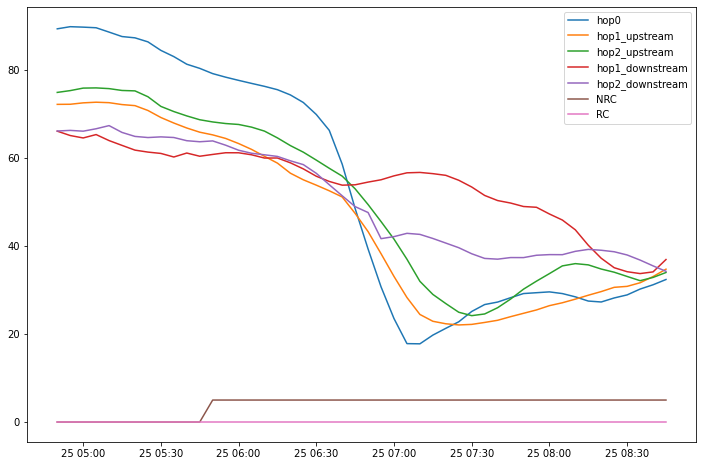

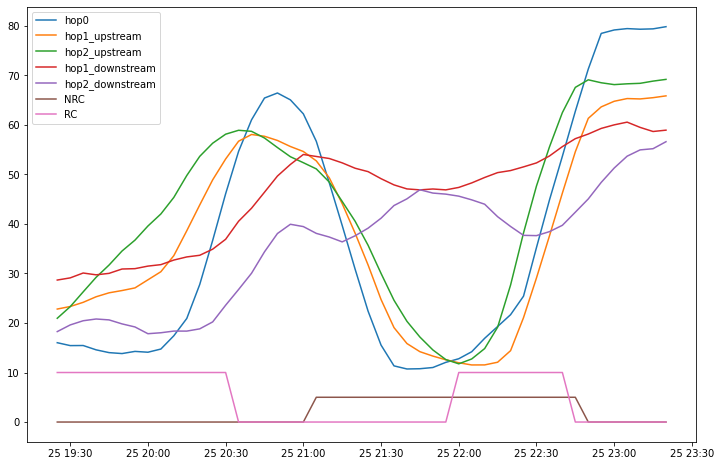

In [470]:
for ix, row in accident_case.iterrows():
#     t = datetime.strptime(row['created'], '%Y-%m-%d %H:%M:%S')
    t = row['created']
    # if (t.month != 12) and (t.month != 1):
    #     continue
    if (t.month > 1):
        continue
    print(t)
    
    t0 = (speed_all.index > t+timedelta(minutes=-120))
    t1 = (speed_all.index <= t+timedelta(minutes=120))
    plt.figure(figsize=(12, 8))
    plt.plot(df_agg_inflow[t0&t1][0], label='hop0')
    plt.plot(df_agg_inflow[t0&t1][1], label='hop1_upstream')
    plt.plot(df_agg_inflow[t0&t1][2], label='hop2_upstream')
    plt.plot(df_agg_outflow[t0&t1][1], label='hop1_downstream')
    plt.plot(df_agg_outflow[t0&t1][2], label='hop2_downstream')
    plt.plot(congestion_label[t0&t1]['NRC']*5, label='NRC')
    plt.plot(congestion_label[t0&t1]['RC']*10, label='RC')
    plt.legend()

In [475]:
congestion_label['label'] = congestion_label['RC']

In [477]:
X_all = []
y_all = []
for i in range(len(speed_all)-12):
    if congestion_label.NRC[i+12] == 1:
        X_all.append(speed_all.iloc[i:i+12, :])
        y_all.append(1)
    elif congestion_label.RC[i+12] == 1:
        X_all.append(speed_all.iloc[i:i+12, :])
        y_all.append(0)
X_all = np.stack(X_all)
y_all = np.stack(y_all)

In [478]:
X_all.shape, y_all.shape

((10382, 12, 25), (10382,))

In [479]:
np.unique(y_all, return_counts = True) 

(array([0, 1]), array([9720,  662]))

In [486]:
# # Recurrent Congestion
# ## smoothing
# rolling_window = 6
# speed_all = df_all_norm.rolling(rolling_window).mean()

# ## nan value
# speed_all = speed_all.bfill(limit=36).ffill(limit=36).fillna(0, limit=288*10).dropna(axis=1)


ff_speed = df_all_norm.quantile(q=0.85, axis=0)
cong_speed = ff_speed * 0.6

congestion_label_test = pd.DataFrame(0, index=df_all_norm.index, columns=['RC'])
for i in range(len(df_all_norm)-12):
    ts = df_all_norm[i:i+12]
    n_cong_road = (ts.mean(axis=0) < cong_speed).sum()
    if n_cong_road > 0.5*df_all_norm.shape[1]:
        congestion_label_test.iloc[i+12] = 1

In [487]:
congestion_label_test['RC'].value_counts()

1    35751
0    16089
Name: RC, dtype: int64

## Congestion Pattern Clustering

In [376]:
len(speed_all), len(congestion_label)

(51840, 51840)

In [377]:
speed_all.shape, speed_all.columns

((51840, 25),
 Int64Index([1210004801, 1210004802, 1210005304, 1210005305, 1210065700,
             1210066100, 1210066300, 1220004700, 1220095000, 1220096900,
             1220342100, 1220342500, 1220342700, 1020026801, 1020056400,
             1210004500, 1210004901, 1210004902, 1210005402, 1210060300,
             1210062100, 1210062500, 1210062700, 1210158699, 1210005301],
            dtype='int64', name='sid'))

In [378]:
congestion_speed_all = []
for i in range(len(speed_all)-12):
    if congestion_label.RC[i+12] == 1:
        congestion_speed_all.append(speed_all.iloc[i:i+12, :])
congestion_speed_all = np.stack(congestion_speed_all)
        

In [379]:
congestion_speed_all.shape

(9745, 12, 25)

In [384]:
from tslearn.clustering import TimeSeriesKMeans

n_cluster = 8

v0_ts_all = np.stack([s[:, -1] for s in congestion_speed_all])
v0_ts_all = np.expand_dims(v0_ts_all, axis=-1)
sz = v0_ts_all.shape[1]
km = TimeSeriesKMeans(n_clusters=n_cluster, verbose=True, random_state=0)
y_pred = km.fit_predict(v0_ts_all)



174.346 --> 141.331 --> 139.009 --> 137.911 --> 137.146 --> 136.501 --> 135.884 --> 135.112 --> 134.375 --> 133.809 --> 133.331 --> 132.987 --> 132.752 --> 132.591 --> 132.479 --> 132.362 --> 132.248 --> 132.158 --> 132.107 --> 132.066 --> 132.022 --> 131.988 --> 131.961 --> 131.936 --> 131.910 --> 131.883 --> 131.854 --> 131.824 --> 131.801 --> 131.779 --> 131.765 --> 131.743 --> 131.722 --> 131.710 --> 131.701 --> 131.693 --> 131.682 --> 131.672 --> 131.662 --> 131.648 --> 131.638 --> 131.632 --> 131.626 --> 131.621 --> 131.617 --> 131.616 --> 131.614 --> 131.611 --> 131.609 --> 131.608 --> 


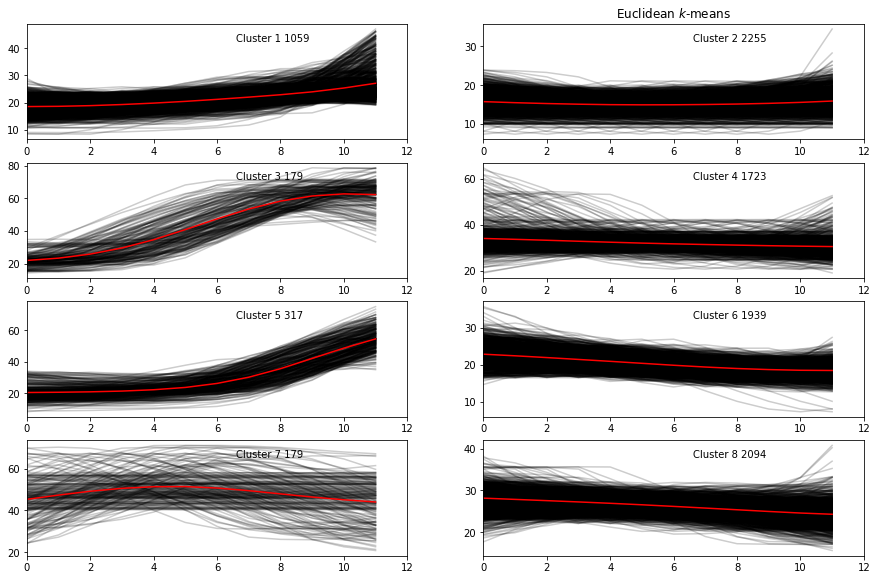

In [389]:
plt.figure(figsize=(15, int(5*n_cluster/2)))
for yi in range(n_cluster):
    plt.subplot(n_cluster, 2, yi + 1)
    for xx in v0_ts_all[y_pred == yi][:1000]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 12)
#     plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d %d' % (yi + 1, (y_pred == yi).sum()),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")
plt.show()

In [116]:
H_node_list = list(np.unique(path_inflow))+list(np.unique(path_outflow))

In [128]:
for ix, row in accident_all.iterrows():
#     if row['accident_sid'] == target_sid:
#         continue
    if row['accident_sid'] in H_node_list:
        print("!!!!")
        print(row['accident_sid'], row['created'])

!!!!
1210004902 2020-09-28 22:31:00
!!!!
1210004802 2020-10-02 20:38:00
!!!!
1210004802 2020-10-12 08:21:18
!!!!
1210005402 2020-11-13 13:37:00
!!!!
1210005304 2020-11-22 10:51:00
!!!!
1210005304 2020-11-22 14:36:00
!!!!
1210005301 2020-11-22 20:24:00
!!!!
1210005301 2020-11-24 07:20:00
!!!!
1210005301 2020-11-24 07:26:19
!!!!
1210004500 2020-11-26 14:07:00
!!!!
1210005402 2020-11-26 14:13:00
!!!!
1210005301 2020-11-29 11:47:24
!!!!
1210005301 2020-12-06 19:31:00
!!!!
1210005301 2020-12-10 06:57:00
!!!!
1210005402 2020-12-10 09:06:00
!!!!
1210005301 2020-12-15 07:10:00
!!!!
1210004902 2020-12-15 13:07:00
!!!!
1210004500 2020-12-17 15:03:00
!!!!
1210004500 2020-12-17 21:47:00
!!!!
1210005402 2020-12-19 11:35:00
!!!!
1210005301 2020-12-21 06:55:00
!!!!
1210005301 2020-12-23 07:54:00
!!!!
1210005402 2020-12-30 10:18:00
!!!!
1210005301 2021-01-02 14:10:00
!!!!
1210005301 2021-01-04 06:46:00
!!!!
1210005301 2021-01-09 12:27:00
!!!!
1210005402 2021-01-09 12:32:00
!!!!
1210005402 2021-01-09 1